In [2]:
import pandas as pd
import os

# 데이터 디렉토리
data_dir = "/home/jovyan/work/data"

all_data = []

# 각 테이블에서 데이터 추출
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # id가 user_id 역할
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# 일반 테이블들 처리
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# 친구 요청 테이블 - 보낸 사람만 포함 (능동적 활동)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 보낸 사람만 (능동적 활동)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# 모든 데이터 병합
merged_df = pd.concat(all_data, ignore_index=True)

# created_at을 datetime으로 변환
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null 값 제거
merged_df = merged_df.dropna(subset=['created_at'])

# user_id로 그룹화하고 created_at으로 정렬
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"총 {len(merged_df):,}개 레코드 병합 완료")
print(f"유니크 사용자 수: {merged_df['user_id'].nunique():,}")
print("\n테이블별 레코드 수:")
print(merged_df['table_name'].value_counts())

총 21,705,813개 레코드 병합 완료
유니크 사용자 수: 677,085

테이블별 레코드 수:
table_name
accounts_friendrequest_send              17147175
accounts_pointhistory                     2338918
accounts_userquestionrecord_processed     1217558
accounts_user_processed                    677085
polls_questionset                          158384
accounts_paymenthistory                     95140
polls_questionreport                        51424
accounts_blockrecord_processed              19449
event_receipts                                309
accounts_timelinereport                       208
accounts_failpaymenthistory                   163
Name: count, dtype: int64


In [14]:
import pandas as pd
import os

# 경로 설정
data_dir = '/home/jovyan/work/data'

# 포인트 이벤트 테이블
events = pd.read_csv(os.path.join(data_dir, 'events.csv'))

# 출석 테이블
accounts_attendance = pd.read_csv(os.path.join(data_dir, 'accounts_attendance.csv'))

# 친구 요청 테이블
accounts_friendrequest = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 학급 테이블
accounts_group = pd.read_csv(os.path.join(data_dir, 'accounts_group.csv'))

# 가까운 학교를 기록해두기 위한 관계형 테이블
accounts_nearbyschool = pd.read_csv(os.path.join(data_dir, 'accounts_nearbyschool.csv'))

# 유저 컨택 테이블
accounts_user_contacts = pd.read_csv(os.path.join(data_dir, 'accounts_user_contacts.csv'))

# 학교 테이블
accounts_school = pd.read_csv(os.path.join(data_dir, 'accounts_school.csv'))

# 포인트 이벤트 참여 테이블
accounts_userwithdraw = pd.read_csv(os.path.join(data_dir, 'accounts_userwithdraw.csv'))

# 질문 내용 테이블
polls_question = pd.read_csv(os.path.join(data_dir, 'polls_question.csv'))

# 질문에 대한 신고 기록 테이블
polls_questionpiece = pd.read_csv(os.path.join(data_dir, 'polls_questionpiece.csv'))

# 질문에 등장하는 유저들 테이블
polls_usercandidate = pd.read_csv(os.path.join(data_dir, 'polls_usercandidate.csv'))


In [15]:
merged_df

,user_id,created_at,table_name
0,831956,2023-03-29 03:44:14.047130,accounts_user_processed
1,831962,2023-03-29 05:18:56.162368,accounts_user_processed
2,831962,2023-07-13 07:51:59.000000,accounts_friendrequest_send
3,832151,2023-03-29 12:56:34.989468,accounts_user_processed
4,832151,2023-04-22 06:02:56.000000,accounts_friendrequest_send
...,...,...,...
21705808,1583732,2024-05-09 07:22:38.387553,accounts_user_processed
21705809,1583732,2024-05-09 07:23:12.000000,accounts_friendrequest_send
21705810,1583732,2024-05-09 07:23:12.000000,accounts_friendrequest_send
21705811,1583732,2024-05-09 07:23:12.000000,accounts_friendrequest_send


In [16]:
merged_df['user_id'].nunique()

677085

In [17]:
# 사용자별 생존기간 계산
user_survival = merged_df.groupby('user_id').agg({
    'created_at': ['first', 'last', 'count']
}).reset_index()

# 컬럼명 정리
user_survival.columns = ['user_id', 'first_activity', 'last_activity', 'total_events']

print(f"사용자 생존기간 테이블 완성: {len(user_survival):,}명")
print(user_survival.head())

사용자 생존기간 테이블 완성: 677,085명
   user_id             first_activity              last_activity  total_events
0   831956 2023-03-29 03:44:14.047130 2023-03-29 03:44:14.047130             1
1   831962 2023-03-29 05:18:56.162368 2023-07-13 07:51:59.000000             2
2   832151 2023-03-29 12:56:34.989468 2023-05-09 15:50:58.000000            11
3   832340 2023-03-29 12:56:35.020790 2023-05-11 00:51:26.000000            29
4   832520 2023-03-29 12:56:35.049311 2023-03-29 12:56:35.049311             1


In [18]:
# 생존일 수 계산 (차이 in days)
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days

# 이탈 유저 (당일 유저): 1, 잔존 유저: 0
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)

print(user_survival['is_churn'].value_counts())
# 1: 이탈 (하루만 활동), 0: 잔존

is_churn
0    441629
1    235456
Name: count, dtype: int64


"당일 유저 중 친구 요청을 한 유저는 더 많은 기능을 사용하고, 더 오래 체류하는가?"    
 -> 전체 사용자 중에서 하루만 활동한 당일유저 추출(위에서 분리했음)    
 -> 당일유저 중에서 로그가 있는 당일유저만 분석 대상으로 함    
 -> 분석 대상 중에서 accounts_friendrequest에서 친구 요청을 보낸 이력이 있는지 여부로 두 그룹 분리    
 -> 전체 행동 수 & 체류 시간등의 차이를 시각적, 통계적으로 비교 함    
    
그룹 간 스케일 차이가 나는듯함

In [19]:
# 당일유저 추출출
day1_users = user_survival[user_survival['is_churn'] == 1]['user_id'].unique()

# 당일 유저만 필터링
day1_merged = merged_df[merged_df['user_id'].isin(day1_users)].copy()

# 행동 요약
summary = day1_merged.groupby('user_id').agg(
    action_count=('table_name', 'count'),
    num_tables_used=('table_name', 'nunique'),
    first_action=('created_at', 'min'),
    last_action=('created_at', 'max')
).reset_index()

# 체류 시간 (초)
summary['duration_seconds'] = (summary['last_action'] - summary['first_action']).dt.total_seconds()



In [20]:
# 친구 요청 유저 목록
friend_senders = accounts_friendrequest['send_user_id'].dropna().unique()
day1_friend_users = set(day1_users).intersection(friend_senders)

summary['friend_request'] = summary['user_id'].isin(day1_friend_users)


In [21]:
summary['friend_request']

0         False
1         False
2         False
3         False
4         False
          ...  
235451    False
235452     True
235453     True
235454     True
235455    False
Name: friend_request, Length: 235456, dtype: bool

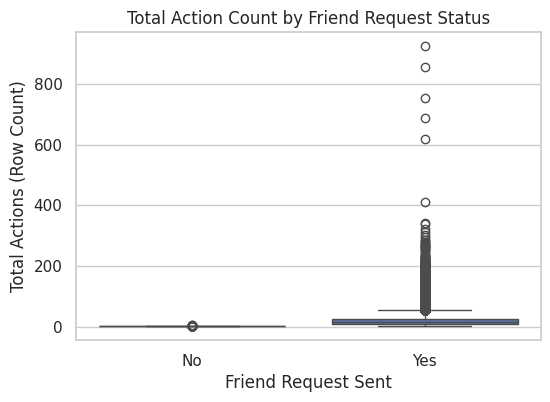

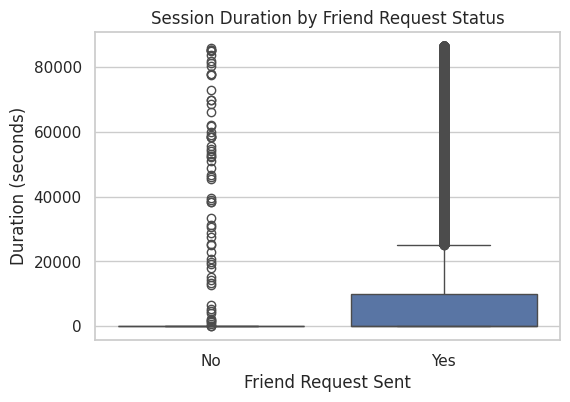

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

sns.set(style='whitegrid')

# 1. 사용자별 전체 행동 수 비교 (row 수)
plt.figure(figsize=(6, 4))
sns.boxplot(data=summary, x='friend_request', y='action_count')
plt.title('Total Action Count by Friend Request Status')  # 행동 수
plt.xlabel('Friend Request Sent')  # 친구 요청 여부
plt.ylabel('Total Actions (Row Count)')  # 행동 수
plt.xticks([0, 1], ['No', 'Yes'])  # False / True
plt.show()

# 2. 사용자별 체류 시간 비교 (최초~최종 활동 시간 간격)
plt.figure(figsize=(6, 4))
sns.boxplot(data=summary, x='friend_request', y='duration_seconds')
plt.title('Session Duration by Friend Request Status')  # 체류 시간
plt.xlabel('Friend Request Sent')
plt.ylabel('Duration (seconds)')  # 체류 시간 (초)
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()



In [23]:
# 그룹 나누기
group_sent = summary[summary['friend_request'] == True]       # 친구 요청한 유저
group_not_sent = summary[summary['friend_request'] == False]  # 친구 요청 안 한 유저

# 행동 수 차이 검정
stat1, p1 = mannwhitneyu(group_sent['action_count'], group_not_sent['action_count'])
print(f'[Action Count] Mann-Whitney U Test p-value: {p1:.10f}')  # 작을수록 유의미한 차이

# 체류 시간 차이 검정
stat2, p2 = mannwhitneyu(group_sent['duration_seconds'], group_not_sent['duration_seconds'])
print(f'[Session Duration] Mann-Whitney U Test p-value: {p2:.10f}')


[Action Count] Mann-Whitney U Test p-value: 0.0000000000
[Session Duration] Mann-Whitney U Test p-value: 0.0000000000


In [24]:
# 그룹별 유저 수
summary['friend_request'].value_counts()


friend_request
True     208444
False     27012
Name: count, dtype: int64

In [25]:
# 맨 휘트니 검정으로 p-value값이 너무 작기 때문에 중앙값 함께 확인
summary.groupby('friend_request')[['action_count', 'duration_seconds']].median()


,action_count,duration_seconds
friend_request,,
False,1.0,0.000000
True,15.0,85.832621


In [26]:
# 두 그룹의 중앙값/평균
summary.groupby('friend_request')[['action_count', 'duration_seconds']].agg(['mean', 'median'])


action_count        duration_seconds           
                       mean median             mean     median
friend_request                                                
False              1.002740    1.0       105.667707   0.000000
True              20.160619   15.0     12673.924391  85.832621

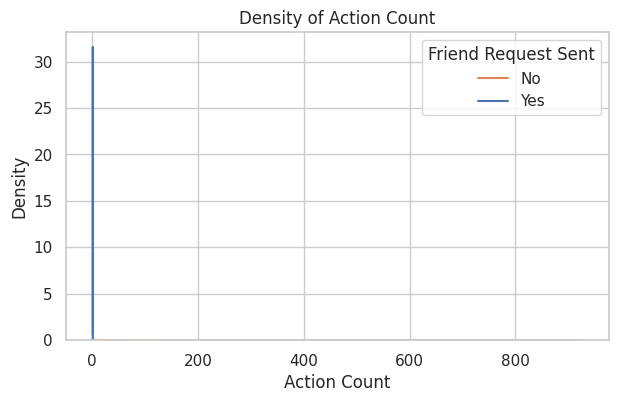

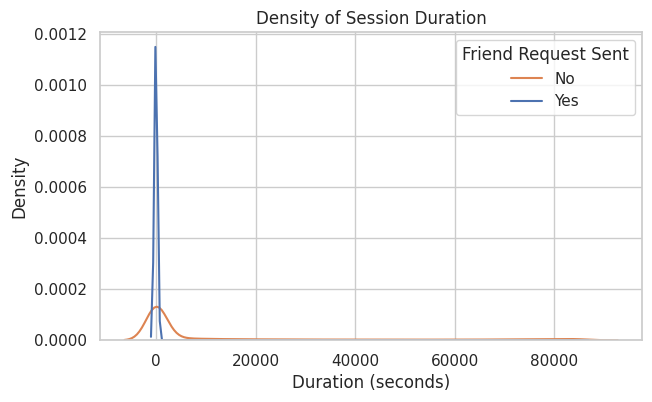

In [27]:
# 행동 수 밀도 분포
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.kdeplot(data=summary, x='action_count', hue='friend_request', common_norm=False)
plt.title('Density of Action Count')
plt.xlabel('Action Count')
plt.ylabel('Density')
plt.legend(title='Friend Request Sent', labels=['No', 'Yes'])
plt.show()

# 체류 시간 밀도 분포
plt.figure(figsize=(7, 4))
sns.kdeplot(data=summary, x='duration_seconds', hue='friend_request', common_norm=False)
plt.title('Density of Session Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.legend(title='Friend Request Sent', labels=['No', 'Yes'])
plt.show()


● 잔존 유저 (왼쪽 위)
분포가 훨씬 넓게 퍼져 있음 (최대 6000 이상)

친구 요청한 유저(파란 선)는 전체적으로 행동량이 크고 고르게 분포

친구 요청 안 한 유저(주황 선)는 거의 0 근처에 몰려 있음

✅ 해석    
→ 친구 요청 유저는 지속적으로 플랫폼을 사용하며 다양한 기능을 많이 사용하는 유저    
→ 잔존 유저 중에서도 친구 요청 여부는 강한 활동성의 신호임     
    
    
● 잔존 유저 (왼쪽 아래)
친구 요청 유저는 짧은 체류 시간 구간에서도 밀집하지만,

전반적으로 더 넓은 구간까지 분포함

비요청 유저는 짧은 시간대에 집중

✅ 해석    
→ 체류 시간이 긴 유저일수록 친구 요청을 했을 확률도 높음
→ ‘머무는 시간’ 자체가 플랫폼 탐색/활동의 일부로 보임

“잔존 유저 중에서도 친구 요청을 한 사람과 그렇지 않은 사람 간의 행동 차이는 존재하는가?”


In [28]:
# 위에서 분리된 잔존유저 리스트 추출
stay_users = user_survival[user_survival['is_churn'] == 0]['user_id'].unique()

In [29]:
# 잔존유저의 활동파악(위와 같음)
stay_merged = merged_df[merged_df['user_id'].isin(stay_users)]

summary_stay = stay_merged.groupby('user_id').agg(
    action_count=('table_name', 'count'),
    num_tables_used=('table_name', 'nunique'),
    first_action=('created_at', 'min'),
    last_action=('created_at', 'max')
).reset_index()

summary_stay['duration_seconds'] = (summary_stay['last_action'] - summary_stay['first_action']).dt.total_seconds()


In [30]:
# 친구요청여부 플래그 추가
friend_senders = accounts_friendrequest['send_user_id'].dropna().unique()
summary_stay['friend_request'] = summary_stay['user_id'].isin(friend_senders)


In [31]:
summary_stay

,user_id,action_count,num_tables_used,first_action,last_action,duration_seconds,friend_request
0,831962,2,2,2023-03-29 05:18:56.162368,2023-07-13 07:51:59,9.167583e+06,True
1,832151,11,2,2023-03-29 12:56:34.989468,2023-05-09 15:50:58,3.552863e+06,True
2,832340,29,3,2023-03-29 12:56:35.020790,2023-05-11 00:51:26,3.671691e+06,True
3,833024,3,2,2023-03-31 09:05:51.903699,2023-05-28 02:44:12,4.988300e+06,True
4,833041,38,3,2023-03-31 14:32:36.425315,2023-07-15 07:48:47,9.134171e+06,True
...,...,...,...,...,...,...,...
441624,1583612,3,3,2024-04-19 15:16:07.876679,2024-05-05 11:06:31,1.367423e+06,True
441625,1583632,38,3,2024-04-23 03:33:31.390794,2024-05-02 09:42:47,7.997556e+05,True
441626,1583634,40,3,2024-04-23 03:34:57.094026,2024-04-30 04:48:25,6.092079e+05,True
441627,1583669,208,2,2024-04-28 14:40:07.345830,2024-04-30 05:47:00,1.408127e+05,True


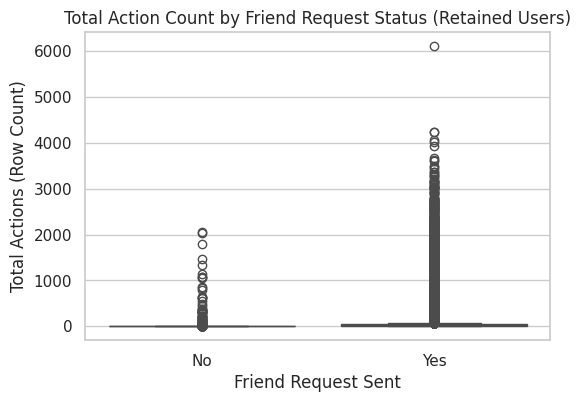

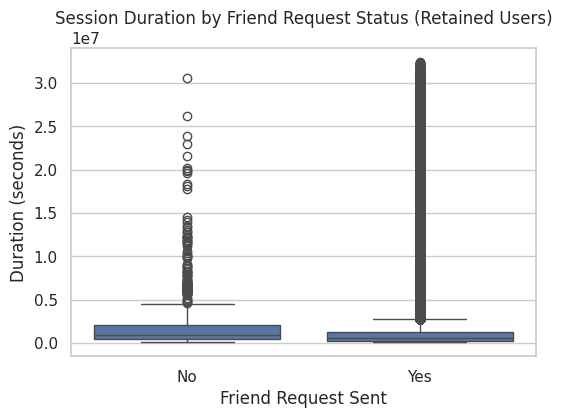

In [32]:
# 시각화
plt.figure(figsize=(6, 4))
sns.boxplot(data=summary_stay, x='friend_request', y='action_count')
plt.title('Total Action Count by Friend Request Status (Retained Users)')
plt.xlabel('Friend Request Sent')
plt.ylabel('Total Actions (Row Count)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=summary_stay, x='friend_request', y='duration_seconds')
plt.title('Session Duration by Friend Request Status (Retained Users)')
plt.xlabel('Friend Request Sent')
plt.ylabel('Duration (seconds)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


In [33]:
# Mann-Whitney U Test
group_sent_stay = summary_stay[summary_stay['friend_request'] == True]
group_not_sent_stay = summary_stay[summary_stay['friend_request'] == False]

stat1_stay, p1_stay = mannwhitneyu(group_sent_stay['action_count'], group_not_sent_stay['action_count'])
stat2_stay, p2_stay = mannwhitneyu(group_sent_stay['duration_seconds'], group_not_sent_stay['duration_seconds'])

print(f'[Action Count - Stay] Mann-Whitney U Test p-value: {p1_stay:.10f}')
print(f'[Session Duration - Stay] Mann-Whitney U Test p-value: {p2_stay:.10f}')

[Action Count - Stay] Mann-Whitney U Test p-value: 0.0000000000
[Session Duration - Stay] Mann-Whitney U Test p-value: 0.0000000000


In [34]:
# 맨 휘트니 검정으로 p-value값이 너무 작기 때문에 중앙값 함께 확인
summary_stay.groupby('friend_request')[['action_count', 'duration_seconds']].median()

,action_count,duration_seconds
friend_request,,
False,2.0,968317.408286
True,26.0,611432.064041


In [35]:
# 두 그룹의 중앙값/평균
summary_stay.groupby('friend_request')[['action_count', 'duration_seconds']].agg(['mean', 'median'])

action_count        duration_seconds               
                       mean median             mean         median
friend_request                                                    
False             30.254745    2.0     2.211642e+06  968317.408286
True              39.593675   26.0     1.215710e+06  611432.064041

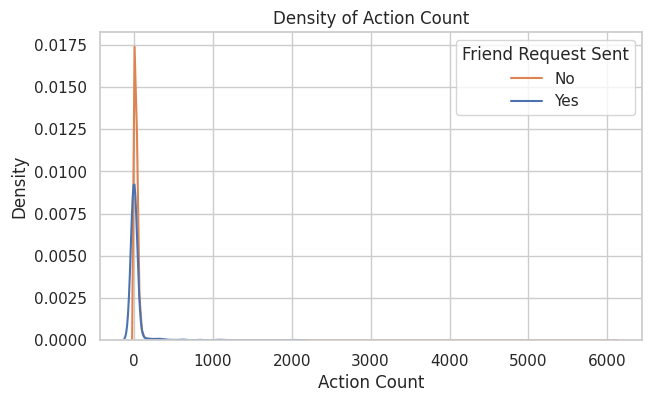

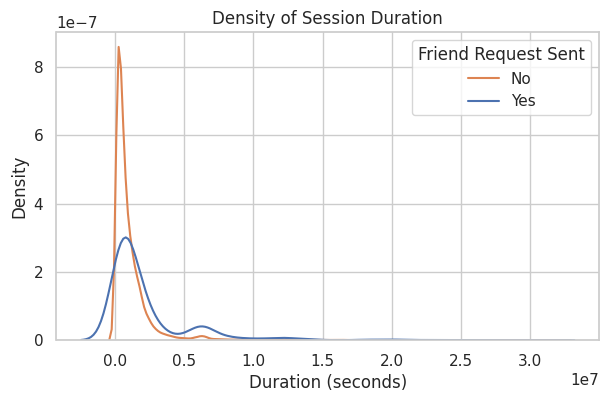

In [36]:
# 행동 수 밀도 분포
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.kdeplot(data=summary_stay, x='action_count', hue='friend_request', common_norm=False)
plt.title('Density of Action Count')
plt.xlabel('Action Count')
plt.ylabel('Density')
plt.legend(title='Friend Request Sent', labels=['No', 'Yes'])
plt.show()

# 체류 시간 밀도 분포
plt.figure(figsize=(7, 4))
sns.kdeplot(data=summary_stay, x='duration_seconds', hue='friend_request', common_norm=False)
plt.title('Density of Session Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.legend(title='Friend Request Sent', labels=['No', 'Yes'])
plt.show()


● 당일 유저 (오른쪽 위)    
전체 행동 수가 대부분 100 미만에 밀집

친구 요청 여부만으로도 뚜렷한 분포 차이 존재

친구 요청 유저는 비요청 유저보다 행동 수가 많지만, 전체적으로는 소수

✅ 해석
→ 당일 유저는 기본적으로 사용량이 적고,
→ 친구 요청 여부는 소수의 적극 유저를 구분하는 역할
→ 이탈 여부 판단용 초기 피처로 적합    

    
    
    ● 당일 유저 (오른쪽 아래)
전체적으로 체류 시간이 매우 짧고 밀집

친구 요청 유저의 분포는 살짝 넓지만 차이가 명확하지는 않음

✅ 해석
→ 이탈 유저 대부분은 짧게 머무르고 떠나며,
→ 친구 요청은 그 안에서 조금 더 머무른 유저의 특징 정도

In [37]:
summary_stay.describe()

,user_id,action_count,num_tables_used,first_action,last_action,duration_seconds
count,4.416290e+05,441629.000000,441629.000000,441629,441629,4.416290e+05
mean,1.189972e+06,39.572508,2.232501,2023-05-13 21:46:25.932924416,2023-05-28 00:05:53.528000,1.217968e+06
min,8.319620e+05,2.000000,2.000000,2023-03-29 05:18:56.162368,2023-04-20 07:37:32,8.640043e+04
25%,1.014408e+06,15.000000,2.000000,2023-05-08 13:47:34.376861952,2023-05-16 06:56:24,2.849746e+05
50%,1.184369e+06,26.000000,2.000000,2023-05-12 14:49:52.584366080,2023-05-23 13:30:52,6.118312e+05
75%,1.360421e+06,41.000000,2.000000,2023-05-17 16:17:39.474123008,2023-05-30 04:56:32,1.296446e+06
max,1.583673e+06,6106.000000,9.000000,2024-04-29 06:43:16.501426,2024-05-09 09:21:47,3.241646e+07
std,2.045133e+05,103.204685,0.534198,NaN,NaN,2.236911e+06


In [38]:
summary.describe()

,user_id,action_count,num_tables_used,first_action,last_action,duration_seconds
count,2.354560e+05,235456.000000,235456.000000,235456,235456,235456.000000
mean,1.256104e+06,17.962787,1.909248,2023-05-19 18:39:37.902924288,2023-05-19 21:46:49.970876672,11232.067953
min,8.319560e+05,1.000000,1.000000,2023-03-29 03:44:14.047130,2023-03-29 03:44:14.047130,0.000000
25%,1.062317e+06,5.000000,2.000000,2023-05-09 15:06:42.126481408,2023-05-09 23:00:32.249999872,10.791544
50%,1.275120e+06,13.000000,2.000000,2023-05-15 01:47:14.430366976,2023-05-15 05:25:29.500000,58.195981
75%,1.464134e+06,24.000000,2.000000,2023-05-23 03:07:17.426854912,2023-05-23 07:18:10.249999872,5097.655720
max,1.583733e+06,925.000000,5.000000,2024-05-09 08:31:17.710824,2024-05-09 08:31:17.710824,86399.672669
std,2.241959e+05,18.541916,0.362175,NaN,NaN,23236.805794


In [39]:
친구요청은 당일유저에게는 "이탈방지 신호" 일 수 있고, 잔존유저에게는 "고 활성 사용자들의 공통 특성"이다.

SyntaxError: invalid syntax (4087176129.py, line 1)

잔존 유저는 당일 유저보다 평균 페이지 이동 수(= 이벤트 수)가 많다??

이건 당일 vs 잔존 유저를 나누고, 각 유저가 남긴 row 수(= 행동 수)를 비교
-> merged_df사용

In [40]:
# 유저별 전체 이벤트 수 (merged_df에는 모든 활동이 있음)
user_action_counts = merged_df.groupby('user_id').size().reset_index(name='action_count')

In [41]:
# user_survival에는 is_churn 컬럼이 있음 (0 = 잔존, 1 = 이탈)
summary = pd.merge(user_survival[['user_id', 'is_churn']], user_action_counts, on='user_id', how='left')

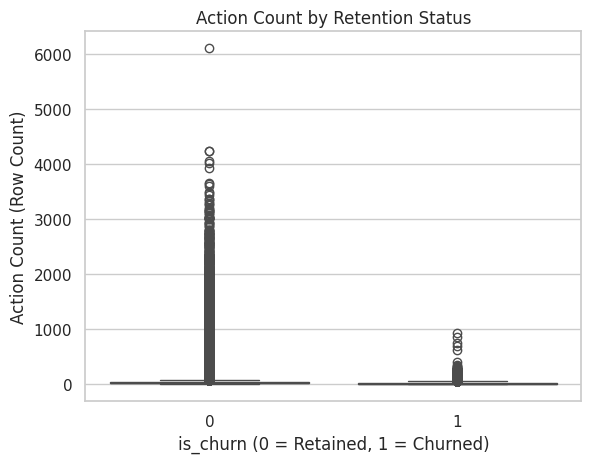

Mann-Whitney U test p-value: 0.0000000000


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# 박스플롯 비교
sns.boxplot(data=summary, x='is_churn', y='action_count')
plt.title('Action Count by Retention Status')
plt.xlabel('is_churn (0 = Retained, 1 = Churned)')
plt.ylabel('Action Count (Row Count)')
plt.show()

# 그룹 나누기
retained = summary[summary['is_churn'] == 0]['action_count']
churned = summary[summary['is_churn'] == 1]['action_count']

# Mann-Whitney U 검정
stat, p = mannwhitneyu(retained, churned)
print(f'Mann-Whitney U test p-value: {p:.10f}')


In [43]:
retained.describe()

count    441629.000000
mean         39.572508
std         103.204685
min           2.000000
25%          15.000000
50%          26.000000
75%          41.000000
max        6106.000000
Name: action_count, dtype: float64

In [44]:
churned.describe()

count    235456.000000
mean         17.962787
std          18.541916
min           1.000000
25%           5.000000
50%          13.000000
75%          24.000000
max         925.000000
Name: action_count, dtype: float64

완전한 1:1은 아니지만, 행동 수가 많을수록 페이지 이동을 많이 했을 가능성이 크다고 봄.    
대부분의 테이블은 유저가 클릭한 수를 밭캉으로 결과 생성 됨 -> 그러므로 행동수는 실제 활동량을 짐작할 수 있는 지표라고 봄
